# Create or manipulate images with the DALL-E API

The following options are available to get access to the DALL-E 2 API:

- Subscribe to the [original OpenAI service](https://openai.com/join/) - recommended option
- Request access to the [Azure OpenAI preview](https://aka.ms/oaiapply)  - express interest for DALL-E, however consider __very limited availability at the moment__   

Instead of the API, you can use the [DALL-E playground](https://labs.openai.com/) for an interactive experience.

The Images API provides three methods for interacting with images:

1. Creating images from scratch based on a text prompt
2. Creating variations of an existing image
3. Creating edits of an existing image based on a new text prompt

OpenAI DALL-E list pricing:

| Resolution  | Price          |
|-------------|----------------|
| 1024 x 1024 | $0.020 / image |
| 512 x 512   | $0.018 / image |
| 256 x 256   | $0.016 / image |

Check out the [OpenAI API documentation](https://beta.openai.com/docs/guides/images) for more information. 

In [1]:
import os
import time
import openai
from PIL import Image
import requests
import math
from io import BytesIO
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
load_dotenv('../.env')

# Original OpenAI DALLE API
openai.api_key = os.getenv('OPENAI_API_KEY')

# Azure OpenAI DALLE
api_key = os.getenv('AOAI_API_KEY') # key of your Azure OpenAI resource
api_base = 'https://aoai-ak.openai.azure.com/' # endpoint of your Azure OpenAI resource
api_version = '2022-08-03-preview'

In [3]:
def show_images(images, cols=2, source='url', savedir=''):
    """
    Get images from URL and display them in a grid. Optionally save or retrieve images to/from local dir. 
    
    Parameters
    ----------
    images : list
        List of image urls or local file paths.
    cols : int
        Number of columns in the grid.
    source : str
        'url' or 'local'
    savedir : str
        Directory to save images to.
    """
    
    if savedir != '':
        os.makedirs(savedir, exist_ok=True)
        
    rows = int(math.ceil(len(images) / cols))

    fig = plt.figure(figsize=(cols * 5, rows * 5)) # specifying the overall grid size

    for i, image_url in enumerate(images):
        plt.subplot(rows, cols,i+1)  
        
        if source == 'url':
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            # save images if savedir is specified
            if savedir != '':
                
                # get list of png files
                png_filenames = [image for image in os.listdir(savedir) if image.endswith('.png')]
                # get highest index from existing files
                if png_filenames == []:
                    max_index = 0
                else:
                    max_index = max([int(filename.strip('.png')) for filename in png_filenames])

                # save new file with index + 1
                new_filename = f'{max_index+1:03d}.png'
                fp = os.path.join(savedir, new_filename)
                img.save(fp, 'PNG')            
            
        else: 
            img = Image.open(image_url) # local file
            plt.title(image_url)

        plt.imshow(img)
        plt.axis('off')

    fig.tight_layout()

    plt.show()

# Create images from prompt
The image generations endpoint allows you to create an original image given a text prompt. The more detailed the description, the more likely you are to get the result that you or your end user want.

Source: [DALL-E 2 Prompt Book](https://dallery.gallery/the-dalle-2-prompt-book/)  

Each image can be returned as either a URL or Base64 data, using the response_format parameter. URLs will expire after an hour.

In [9]:
openai_response = openai.Image.create(
  prompt= "A 3D render of a rainbow colored hot air balloon flying above a reflective lake",
  n= 4,
  size= "1024x1024",
  response_format = 'url', # url or b64_json 
  user = '', # represents end user for creating multiuser apps
)

images = [image['url'] for image in openai_response['data']]

"""
A 3D render of a rainbow colored hot air balloon flying above a reflective lake
A magical running shoe, futuristic, stunning product studio photography, low-key lighting, bokeh, smoke effects
"""

'\nA 3D render of a rainbow colored hot air balloon flying above a reflective lake\nA magical running shoe, futuristic, stunning product studio photography, low-key lighting, bokeh, smoke effects\n'

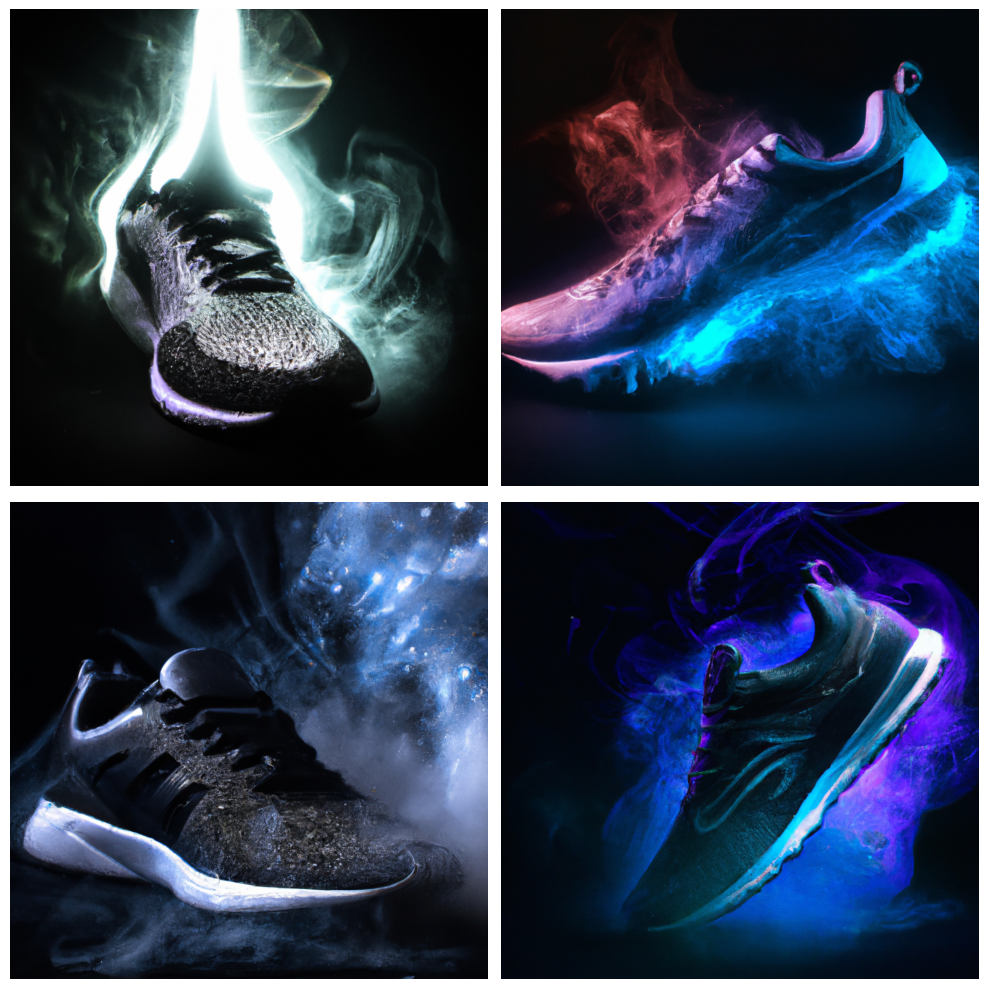

In [ ]:
show_images(images, savedir='./results/balloon/')

## Content Moderation
Prompts and images are filtered based on OpenAI's content policy, returning an error when a prompt or image is flagged.

In [6]:
try:
    openai_response = openai.Image.create(
    prompt="A portrait of Barack Obama",
    n=1,
    size="1024x1024",
    response_format = 'url', 
    user = '', # represent end user for creating multiuser apps
    )
except openai.error.OpenAIError as e:
  print(e.http_status)
  print(e.error)

400
{
  "code": null,
  "message": "Your request was rejected as a result of our safety system. Your prompt may contain text that is not allowed by our safety system.",
  "param": null,
  "type": "invalid_request_error"
}


In [7]:
try:
    openai_response = openai.Image.create(
    prompt="A photo of Mick Jagger, photorealistic, high quality, 8k",
    n=4,
    size="1024x1024",
    response_format = 'url', 
    user = '', # represent end user for creating multiuser apps
    )
except openai.error.OpenAIError as e:
  print(e.http_status)
  print(e.error)

images = [image['url'] for image in openai_response['data']]

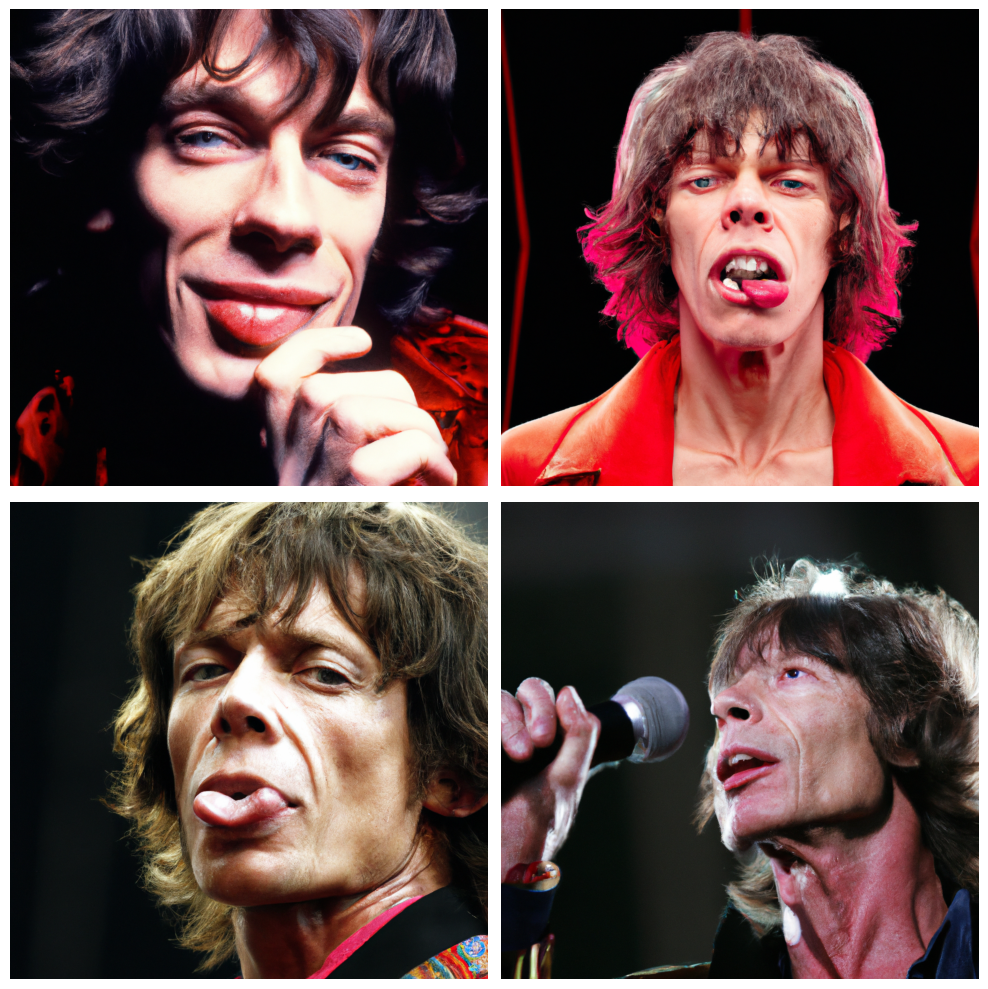

In [8]:
show_images(images, savedir='./results/Jagger/')

# savedir = './results/marilyn/'

# png_filenames = [os.path.join(savedir, image) for image in os.listdir(savedir) if image.endswith('.png')]
# show_images(png_filenames, source='local')

# AOAI DALLE 2 Private Preview
The current preview supports REST calls to the API for prompt based image generation. We are creating a helper function `create_aoai_dalle_images` for a similar usage as with the OpenAI API used above.

In [ ]:
def create_aoai_dalle_images(prompt, resolution = "1024x1024", n=4):
    """
    Call Azure OpenAI API to create n DALLE images based on prompt. 
    
    Parameters
    ----------
    prompt : str
        Image caption prompt.
    resolution : str
        Target resolution of image.
    n : int
        Number of images to create.
    """
    urls = []
    for image_idx in range(n):

        url = "{}dalle/text-to-image?api-version={}".format(api_base, api_version)

        headers= { "api-key": api_key, "Content-Type": "application/json" }
        body = {
        "caption": prompt,
        "resolution": resolution,
        }

        submission = requests.post(url, headers=headers, json=body)
        operation_location = submission.headers['Operation-Location']
        retry_after = submission.headers['Retry-after']
        status = ""

        try:
            while (status != "Succeeded"):
                time.sleep(int(retry_after))
                response = requests.get(operation_location, headers=headers)
                status = response.json()['status']
            
            image_url = response.json()['result']['contentUrl']
            urls.append(image_url)
        except Exception as e:
            print(f"Exception while generating image {image_idx} of {n}. Skipping image.")
            print(e)
    return urls

In [ ]:
urls = create_aoai_dalle_images(prompt='a realistic photographic close up of a floating transparent cup of coffee with liquid splashing in zero gravity with light rays refracting through the coffee',
                                resolution = "1024x1024",
                                n = 6)

savedir = './AOAIDALLE/coffee'

png_filenames = [os.path.join(savedir, image) for image in os.listdir(savedir) if image.endswith('.png')]
show_images(png_filenames, cols=3, source='local')

# Create variations of an existing image
The image variations endpoint allows you to generate a variation of a given image. Input image needs to be `.png` format with squared dimensions and a max file size size of 4 MB.
## General Sample

In [ ]:
# existing image

plt.figure(figsize=(6,6))

img = Image.open('./source/bird.png')
plt.imshow(img)
plt.axis('off')

plt.show()

In [ ]:
response = openai.Image.create_variation(
  image=open("bird.png", "rb"),
  n=10,
  size="1024x1024"
)

images = [image['url'] for image in response['data']]

In [ ]:
show_images(images, cols = 3, savedir='./results/bird/')

## Person

In [ ]:
plt.figure(figsize=(6,6))

img = Image.open('./source/smile.png')
plt.imshow(img)
plt.axis('off')

plt.show()

In [ ]:
response = openai.Image.create_variation(
  image=open("smile.png", "rb"),
  n=10,
  size="1024x1024"
)

images = [image['url'] for image in response['data']]

In [ ]:
savedir = './results/smile/'

png_filenames = [os.path.join(savedir, image) for image in os.listdir(savedir) if image.endswith('.png')]
show_images(png_filenames, cols=3, source='local')

# Replace objects in an image
The image edits endpoint allows you to edit and extend an image by uploading a mask. The transparent areas of the mask indicate where the image should be edited, and the prompt should describe the full new image, not just the erased area.
Image and mask files need to be `.png` format, less than 4 MB size and have squared dimensions.

In [ ]:
source_image = './source/sandwich.png'
mask_image = './source/sandwich-mask.png'

show_images([source_image, mask_image], source='local')

In [ ]:
response = openai.Image.create_edit(
  image=open(source_image, "rb"),
  mask=open(mask_image, "rb"),
  prompt="photo of a hamburger on wood",
  n=10,
  size="1024x1024"
)
images = [image['url'] for image in response['data']]

In [ ]:
show_images(images, savedir='./results/food/')

In [ ]:
source_image = './source/balloon.png'
mask_image = './source/balloon-mask.png'

show_images([source_image, mask_image], source='local')

In [ ]:
response = openai.Image.create_edit(
  image=open(source_image, "rb"),
  mask=open(mask_image, "rb"),
  prompt="photo of a games of thrones dragon flying in the sky",
  n=10,
  size="1024x1024"
)
images = [image['url'] for image in response['data']]

In [ ]:
show_images(images, cols=3, savedir='./results/sky/')

In [ ]:
show_images(images, cols=3, savedir='./results/sky/')